### Homework 4
Felipe Alves - N14713445

#### Question 
Show the downward bias of the OLS estimate of $\alpha$ in the AR1 process

$$ X_{t+1} = \beta + \alpha X_{t} + \sigma W_{t+1}, \quad \{W_t\} \sim \mathcal{N}(0,1) $$

for sample sizes $n=50,100,150, \ldots, 500$. 

Going to paralelize the code to make it run faster

In [1]:
addprocs(6)
@everywhere begin

type AR1
    β::Float64
    α::Float64
    σ::Float64
end
    
function ar1_sim!(y::Vector{Float64},n::Int64,ar::AR1)
    β, α, σ = ar.β, ar.α, ar.σ
    y[1] = β/(1-α)
    for t=1:n
        y[t+1] = β + α * y[t] + σ * randn()
    end
    return Void 
end

function ols{T}(x::Vector{T},y::Vector{T})

    n    = length(x)
    X    = [ones(n) x]
    βhat = ((X'*X) \ (X'*y))[2]
end

function ols{T}(X::Matrix{T},y::Vector{T})

    βhat = ((X'*X) \ (X'*y))[2]
end

    
end

### Some Testing

In [2]:
ar = AR1(.0,.5,1.0)
n = 10^6
y = zeros(n+1);

In [6]:
@time ar1_sim!(y,n,ar)

Void

0.011330 seconds (4 allocations: 160 bytes)


In [7]:
@time  ols(y[1:end-1],y[2:end])

0.5007419816761053

0.030415 seconds (31 allocations: 38.148 MB, 13.34% gc time)


In [8]:
X = [ones(n) y[1:end-1]]
@time  ols(X,y[2:end])

0.5007419816761053

0.007165 seconds (22 allocations: 7.630 MB)


In [9]:
#Non parallel function 

function main1(Eα̂,N,α,Nsim = 10000)    
    
    for i in eachindex(α) 
        ar1 = AR1(.0,α[i],1.0)

        for nind in eachindex(N)
            n = N[nind]
            X = Array(Float64,n,2)
            fill!(X,1.0)
            y = Array(Float64,(n+1))
            αhat = .0
            for rep = 1:Nsim
                ar1_sim!(y,n,ar1)
                X[:,2] = y[1:end-1]
                αhat += ols(X,y[2:end])
            end            
            Eα̂[nind,i] = αhat/Nsim
        end
    end

    return Void
end

main1 (generic function with 2 methods)

In [10]:
#parallel function
function main2(Eα̂,N,α,Nsim = 10000)    
    
@sync @parallel for i in eachindex(α)
        
        ar1 = AR1(.0,α[i],1.0)

        for nind in eachindex(N)
            n = N[nind]
            y = Array(Float64,(n+1))
            αhat = .0
            for rep = 1:Nsim
                ar1_sim!(y,n,ar1)
                αhat += ols(y[1:end-1],y[2:end])
            end            
            Eα̂[nind,i] = αhat/Nsim
        end
    end

    return Void
end

main2 (generic function with 2 methods)

In [15]:
N = 50:50:500
α = [.5,.6,.7,.8,.9]
Eα̂ = zeros(length(N),length(α))

@time main1(Eα̂,N,α)

4.490780 seconds (13.80 k allocations: 1.037 MB)
  

Void

In [18]:
Eα̂ = SharedArray(Float64,(length(N),length(α)))

@time main2(Eα̂,N,α)

Void

1.942254 seconds (13.75 k allocations: 1.039 MB)


### Plot

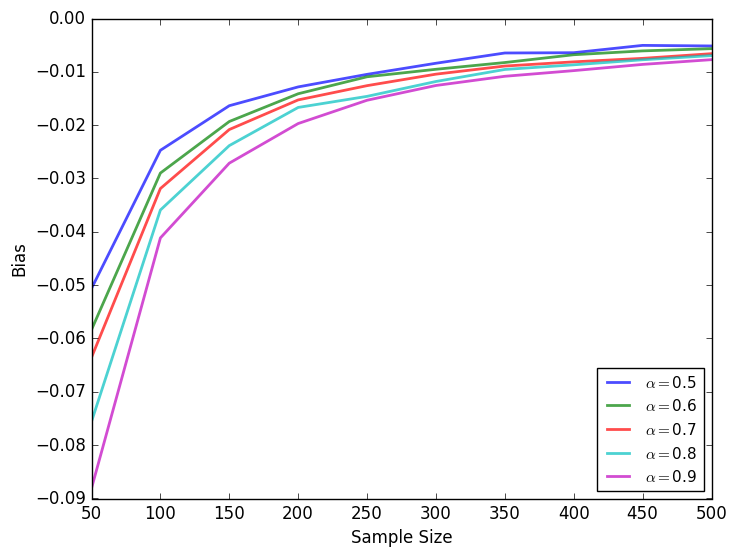

In [20]:
using PyPlot

fig, ax = subplots(figsize = (8,6))
for (i,alp) in enumerate(α)    
    ax[:plot](collect(N), Eα̂[:,i]-alp, label = string(L"$\alpha =$","$alp"), lw = 2, alpha = 0.7)    
end
ax[:legend](loc= "lower right", fontsize = 11)
ax[:set_xlabel]("Sample Size")
ax[:set_ylabel]("Bias")
fig[:show]()
